# 02 - Segmentation Validation

## Imports

In [1]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import avn.dataloading as dataloading
import avn.segmentation as segmentation
import avn.plotting
import math
import sklearn
import seaborn as sns

In [2]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_file']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [3]:
from scipy.io import wavfile
import librosa
import re
import scipy.signal
import pandas as pd
class SongFile:
    """
    Data and metadata pertaining to a single audio file.
    
    
    Attributes
    ----------
    data: ndarray
        Contains audio data of wavfile. 
    
    sample_rate: int
        Sample rate of song data. Based on native sample rate of wavfile.
    
    duration: float
        Duration of the audio file in seconds. 
    
    file_path: str
        Path to the local .wav file used to instantiate the SongFile object.
    
    Methods
    -------
    bandpass_filter(lower_cutoff, upper_cutoff)
        Applies a hamming window bandpass filter to the audio data. 
    
    """
    def __init__(self, file_path):
        """
        Parameters
        ----------
        file_path : str
            Path to the local .wav file to be loaded as a SongFile object.
             
        """
        self.sample_rate, self.data = wavfile.read(file_path)
        self.data = self.data.astype(float)
        self.duration = librosa.get_duration(y = self.data, sr = self.sample_rate)
        self.file_path = file_path
        
        #get file name -- This may be windows specific. 
        file_name_regex = re.compile("\\\\")
        self.file_name = file_name_regex.split(self.file_path)[-1]
                                                  
    def bandpass_filter(self, lower_cutoff, upper_cutoff):
        """
        Applies a hamming window bandpass filter to the audio data.

        Parameters
        ----------
        lower_cutoff : int
            Lower cutoff frequency in Hz for the filter. 
        upper_cutoff : int
            Upper cutoff frequency in Hz for the filter. 

        Returns
        -------
        None.

        """
        #create hamming window filter
        filter_bandpass = scipy.signal.firwin(101, cutoff = [lower_cutoff, upper_cutoff], 
                                              fs = self.sample_rate, 
                                              pass_zero = False)
        #apply filter to audio data
        self.data = scipy.signal.lfilter(filter_bandpass, [1.0], self.data)

In [4]:
dataloading.SongFile = SongFile

In [5]:
def make_spec(syll_wav, hop_length, win_length, n_fft, amin, ref_db, min_level_db):
    spectrogram = librosa.stft(syll_wav, hop_length = hop_length, win_length = win_length, n_fft = n_fft)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), amin = amin, ref = ref_db)
    
    #normalize
    S_norm = np.clip((spectrogram_db - min_level_db) / -min_level_db, 0, 1)
    
    return S_norm
def clean_syll_table(syll_table): 
  '''
  Reformats syll tables imported from evsonganaly so that they are compatible
  with python generated ones

  Inputs
  ----
  syll_table: Pandas Dataframe, imported from a csv containing evsonganaly 
  segmentation and labeling info

  Outputs
  ----
  syll_table: Pandas Dataframe, now with corrected file names and timestamps in seconds

  Notes
  -----
  This function specifically removes .not.mat file extensions from the file names
  so that they are simply .wav and can be compared to file names in the MFCC
  segmentation generated syllable tables. It also converts the timestamps of 
  onsets and offsets from miliseconds to seconds, again so that it is consistent
  with the MFCC resuls
  ''' 

  syll_table['onsets'] = syll_table['onsets'] / 1000
  syll_table['offsets'] = syll_table['offsets'] / 1000

  syll_table['files'] = syll_table['files'].str.split('.not', 1).str[0]

  return syll_table
def plot_confusion_matrix(all_matches):
  temp_df = pd.DataFrame({"hand_labels": all_matches.hand_label, 
                          "clusters": all_matches.hdbscan_labels})
  conf_mat = pd.crosstab(temp_df.hand_labels, temp_df.clusters)
  conf_mat = conf_mat.div(conf_mat.sum(axis = 1), axis = 0) * 100

  plt.figure(figsize = (8,6))
  sns.heatmap(conf_mat, annot = True, fmt='.0f')
def merge_hdbscan_hand_dfs(hdbscan_df, hand_df):
  
  all_matches = pd.DataFrame()

  for song_file in hdbscan_df.files.unique():
    hdbscan_file = hdbscan_df[hdbscan_df.files == song_file]
    hdbscan_file = hdbscan_file.reset_index(drop = True)
    hand_file = hand_df[hand_df.files == song_file]

    if hand_file.shape[0] != 0:
      hand_onsets = hand_file.onsets
      hdbscan_onsets = hdbscan_file.onsets
      best_matches = get_best_matches(hand_onsets, hdbscan_onsets, max_gap = 0.1)
      matches_file = pd.DataFrame({"files" : song_file,
                                 "best_match" : best_matches.astype(int), 
                                 "hand_onset" : hand_file.onsets, 
                                 "hand_offset" : hand_file.offsets, 
                                 "hand_label" : hand_file.labels})
      matches_file = matches_file.merge(right = hdbscan_file, 
                                        left_on = 'best_match', 
                                        how = 'outer', 
                                        right_index = True)
    all_matches = all_matches.append(matches_file)

  return all_matches

def get_best_matches(first_onsets, second_onsets, max_gap = 0.1):
  '''
  Finds the best unique matches between timestamps in two sets, calcuated in different
  ways on the same file. These can reflect syllable onset or offset timestamps, 
  although I refer to them only as onsets for simplicity. 

  Inputs
  ------
  first_onsets: Pandas Series, Contains the timestamps in seconds of syllable onsets
  calculated with a particular method. 

  second_onsets: Pandas Seris, Contains the timestamps in seconds of syllable onsets
  calculated with a different method. 

  max_gap: int > 0, optional, maximum allowable time difference  in seconds 
  between onsets where they will still be considered a match.

  Outputs
  -------
  best_matches: numpy array, 1D, For every syllable onset in `first_onsets` it 
  contains the index of the best unique match in `second_onsets`. If there is 
  no unique match within the allowable `max_gap`, the value of the match is 
  `NaN`. 
  '''
  first_grid, second_grid = np.meshgrid(first_onsets, second_onsets)
  delta_t_grid = abs(first_grid - second_grid)

  #set max gap threshold
  delta_t_grid = np.where(delta_t_grid > max_gap, np.inf, delta_t_grid)

  if delta_t_grid.shape[0] == 0:
    best_matches = np.array([])
    return best_matches ############################################################################test

  #find best matches
  best_matches = np.argmin(delta_t_grid, axis = 0).astype(float)

  #remove matches were delta t is > max_gap
  for i, match_index in enumerate(best_matches):
    if np.isinf(delta_t_grid[int(match_index), i]):
      best_matches[i] = np.NaN 

  best_matches_previous = best_matches.copy()   

  #Deal with duplicate values by setting the second best matches to their second best pairs
  best_matches, delta_t_grid = correct_duplicates(best_matches, delta_t_grid)

  #check if there were changes made by checking for duplicates. If so, repeat duplicate check.
  if not np.allclose(best_matches, best_matches_previous):
    best_matches, delta_t_grid = correct_duplicates(best_matches, delta_t_grid)

  #make sure duplicate corrections didn't result in out of order matches. 
  for i, curr_match in enumerate(best_matches):
     if i+1 < len(best_matches):
       if curr_match > best_matches[i+1]:
         best_matches[i+1] = np.nan

  return best_matches
def correct_duplicates(best_matches, delta_t_grid):
  '''
  Finds any duplicate matches in the set of best matches, removes duplicates
  by setting all but best match to their second best match. 

  Inputs
  -----
  best_matches: numpy array, 1D, contains indices of onsets in one set which best 
  match the onsets in another set. 

  delta_t_grid: numpy array, 2D, contains all the absolute value time differences
  between all possible pairs of onsets in two sets being compared.

  Outputs
  -----
  best_matches: numpy array, 1D. Same as input, but with duplicate matches corrected

  delta_t_grid: numpy array, 2D. Same as input, but with values at duplicated 
  positions adjusted to allow finding second best match. 


  '''
  for i, match_index in enumerate(best_matches):
    if np.isnan(match_index):
      continue
    #check if match index is duplicated
    if len(np.argwhere(best_matches == match_index)) > 1: 
      #create list of indices of duplicates
      duplicates = np.nonzero(best_matches == match_index)[0]
      #find which duplicate has the smallest delta t
      delta_ts = []
      for n in duplicates:
        delta_ts.append(delta_t_grid[int(best_matches[n]), n])

      #get all but the best matches of the duplicates
      bad_matches = np.delete(duplicates, np.argmin(delta_ts))

      #find second best matches for all but the best duplicate matches

      for bad_match in bad_matches:
        delta_t_grid[int(best_matches[bad_match]), bad_match] = np.inf
        best_matches[bad_match] = np.argmin(delta_t_grid[:, bad_match])
        if np.isinf(np.min(delta_t_grid[:, bad_match])):
          best_matches[bad_match] = np.NaN
  return (best_matches, delta_t_grid)
def remove_nas_from_merge(all_matches, fill_char = 'x', fill_int = 1000):
  
  all_matches.hand_label = all_matches.hand_label.fillna(fill_char)
  all_matches.hdbscan_labels = all_matches.hdbscan_labels.fillna(fill_int)

  return all_matches

## Get List of Birds

In [6]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "Y433", "Y453"] 

#All_Birds should contain 35 bird IDs. Check: 
len(All_Birds)

35

## Dataset Information

In [7]:
n_files = []

for Bird_ID in All_Birds:
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'
    seg_data = pd.read_csv(ground_truth_path)
    n_files.append((len(seg_data.files.unique())))
    

In [8]:
print(min(n_files))
print(max(n_files))
print(np.median(n_files))

17
65
48.0


# Onsets

## Calc F1 Scores

In [7]:
all_seg_metrics = pd.DataFrame()
for Bird_ID in All_Birds[:]:

    #load whisperseg segmentation and reformat so it's consistent with avn
    wseg_segmentations = pd.read_csv('E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv")
    wseg_segmentations = wseg_segmentations.drop(columns = ['Unnamed: 0', 'cluster'])
    wseg_segmentations = wseg_segmentations.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})
    
    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, wseg_segmentations)
    #load ground truth segmentation and add to seg_data object
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #drop any files that aren't in the true seg table as they will cause errors
    to_drop = set(seg_data.seg_table.files.unique()) - set(seg_data.true_seg_table.files.unique())
    seg_data.seg_table = seg_data.seg_table[~seg_data.seg_table.files.isin(to_drop)]

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.01
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #load tweetynet segmentations
    tweety_segs = pd.read_csv('E:\\Final_Bird_Dataset\\Old_Tweety_Segmentation\\' + Bird_ID + '.annot.csv')
    tweety_segs = vak_to_syll_table(tweety_segs)

    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, tweety_segs)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate F1 score for Tweetynet
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.01
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])



In [8]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.918782,1.000000,0.849765,B145,0.05,whisper_seg
0,0.860104,0.954023,0.783019,B145,0.01,whisper_seg
0,0.838174,0.831276,0.845188,B145,0.05,Tweety_net
0,0.699739,0.761364,0.647343,B145,0.01,Tweety_net
0,0.937974,0.988711,0.892190,B236,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.984900,0.985811,0.983990,Y433,0.01,Tweety_net
0,0.973851,0.998958,0.949975,Y453,0.05,whisper_seg
0,0.941086,0.970542,0.913366,Y453,0.01,whisper_seg
0,0.974070,0.970746,0.977418,Y453,0.05,Tweety_net


## Get RMSE segmentation metrics

In [9]:
all_F1s = pd.DataFrame()

for i, Bird_ID in enumerate(All_Birds):
    print("Bird: " + str(i) + "/" + str(len(All_Birds)))
    
    song_folder = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/"+ Bird_ID + "/"
    ground_truth_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/" + Bird_ID + "/" + Bird_ID + "_syll_table.csv"
    
    #do MFCC Segmentation
    segmenter = segmentation.RMSEDerivative()
    seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                 upper_threshold = 0.006, 
                                                 lower_threshold = -0.1)
    
    #Add ground truth data
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    
    seg_metrics = seg_data.seg_metrics
    seg_metrics["Bird_ID"] = [Bird_ID]
    all_F1s = all_F1s.append(seg_metrics)


Bird: 0/36
Bird: 1/36
Bird: 2/36
Bird: 3/36
Bird: 4/36
Bird: 5/36
Bird: 6/36
Bird: 7/36
Bird: 8/36
Bird: 9/36
Bird: 10/36
Bird: 11/36
Bird: 12/36
Bird: 13/36
Bird: 14/36
Bird: 15/36
Bird: 16/36
Bird: 17/36
Bird: 18/36
Bird: 19/36
Bird: 20/36
Bird: 21/36
Bird: 22/36
Bird: 23/36
Bird: 24/36
Bird: 25/36
Bird: 26/36
Bird: 27/36
Bird: 28/36
Bird: 29/36
Bird: 30/36
Bird: 31/36
Bird: 32/36
Bird: 33/36
Bird: 34/36
Bird: 35/36


In [10]:
all_F1s['method'] = 'RMSE'
all_F1s['max_gap'] = 0.01

In [11]:
all_seg_metrics = pd.concat([all_seg_metrics, all_F1s])

In [12]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.918782,1.000000,0.849765,B145,0.05,whisper_seg
0,0.860104,0.954023,0.783019,B145,0.01,whisper_seg
0,0.838174,0.831276,0.845188,B145,0.05,Tweety_net
0,0.699739,0.761364,0.647343,B145,0.01,Tweety_net
0,0.937974,0.988711,0.892190,B236,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.716472,0.711986,0.721014,B524,0.01,RMSE
0,0.575041,0.530426,0.627851,O434,0.01,RMSE
0,0.799800,0.755913,0.849097,S389,0.01,RMSE
0,0.702111,0.601307,0.843521,Y433,0.01,RMSE


In [13]:
all_seg_metrics.to_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s.csv')

## Plot F1 Scores

In [99]:
all_seg_metrics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s.csv')

In [100]:
all_seg_metrics = all_seg_metrics[all_seg_metrics.Bird_ID != 'S389']

In [101]:
all_birds = pd.read_csv("D:\\Final_Bird_Dataset\\old_Bird_list.csv")
all_seg_metrics = pd.merge(all_seg_metrics, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

In [102]:
group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
all_seg_metrics['Group'] = [group_dict[x] for x in all_seg_metrics.Condition]

In [103]:
import seaborn as sns

In [104]:
all_seg_metrics = all_seg_metrics[all_seg_metrics.max_gap == 0.01]

In [105]:
all_seg_metrics.method = pd.Categorical(all_seg_metrics.method).reorder_categories(['RMSE', 'Tweety_net', 'whisper_seg'])
all_seg_metrics.method = all_seg_metrics.method.cat.rename_categories({'Tweety_net' : "TweetyNet", 
                                                                       'whisper_seg' : "WhisperSeg"})

In [106]:
plt.rcParams.update({'font.size': 11})

In [107]:
all_seg_metrics.groupby('method').mean(numeric_only=True)

,Unnamed: 0,F1,precision,recall,max_gap
method,,,,,
RMSE,0.0,0.593817,0.555466,0.643462,0.01
TweetyNet,0.0,0.823950,0.879340,0.789961,0.01
WhisperSeg,0.0,0.881746,0.972087,0.816057,0.01


In [73]:
from scipy.stats import sem
print(sem(all_seg_metrics[all_seg_metrics.method == 'WhisperSeg'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'TweetyNet'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'RMSE'].F1))

0.01537009149584627
0.025762225287049374
0.022392037716349334


In [74]:
all_seg_metrics.groupby(['method', 'Group']).mean(numeric_only=True)

Unnamed: 0        F1  precision    recall  max_gap
method     Group                                                      
RMSE       FP1 KD          0.0  0.589694   0.558265  0.630505     0.01
           Isolate         0.0  0.584960   0.531374  0.656027     0.01
           Normal          0.0  0.598803   0.564123  0.642971     0.01
TweetyNet  FP1 KD          0.0  0.787970   0.924633  0.715029     0.01
           Isolate         0.0  0.813244   0.828697  0.803781     0.01
           Normal          0.0  0.840826   0.883744  0.810660     0.01
WhisperSeg FP1 KD          0.0  0.849318   0.978986  0.760159     0.01
           Isolate         0.0  0.934973   0.970569  0.903424     0.01
           Normal          0.0  0.871805   0.970279  0.800674     0.01

Text(0.5, 13.722222222222216, 'Method')

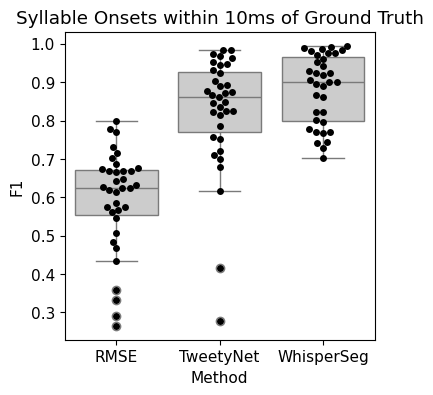

In [75]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')

In [19]:
sns.__version__

'0.13.2'

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


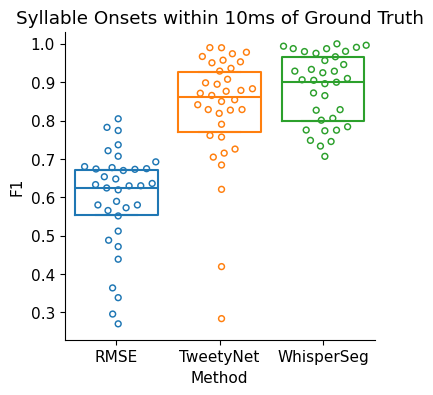

In [34]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', hue = 'method', s = 8, marker = "$\circ$")
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', fill = False, hue = 'method', fliersize=0, whis = 0)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
sns.despine()

C:\Users\tkoch\AppData\Local\Temp\ipykernel_5532\473173597.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'F1', fill = False, color = 'black', fliersize=0, whis= 0,


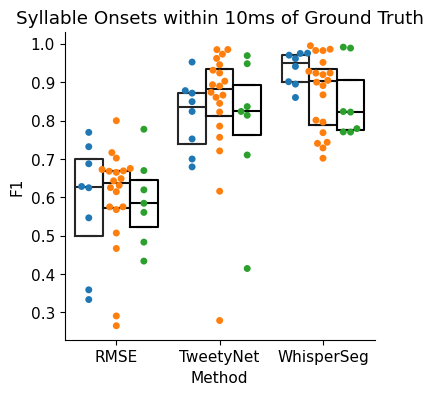

In [77]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', hue = 'Group', s = 5, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'F1', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
sns.despine()

Text(0, 0.5, 'Precision')

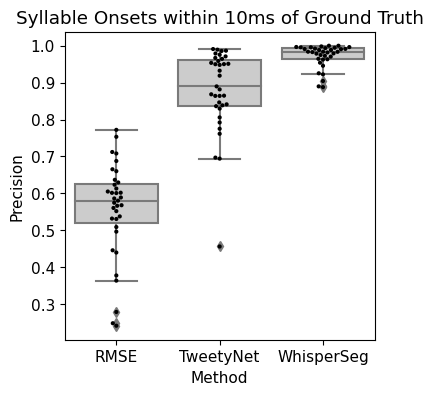

In [39]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', color = 'black', s = 3)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')

Text(10.347222222222223, 0.5, 'Precision')

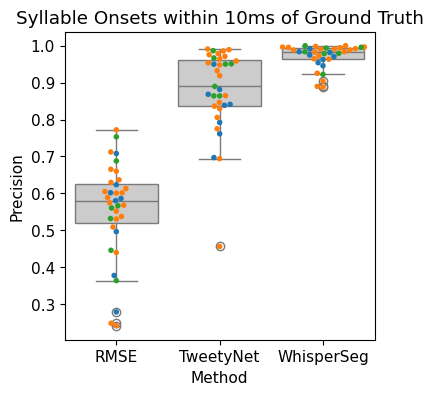

In [76]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', hue = 'Group', s = 4,)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_5532\3604604799.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'precision', fill = False, color = 'black', fliersize=0, whis= 0,


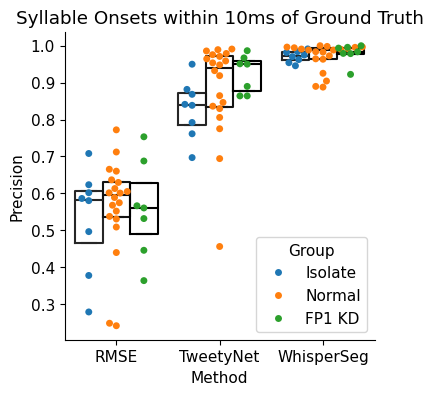

In [108]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', hue = 'Group', s = 5, dodge = True,)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'precision', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')
sns.despine()

Text(0, 0.5, 'Recall')

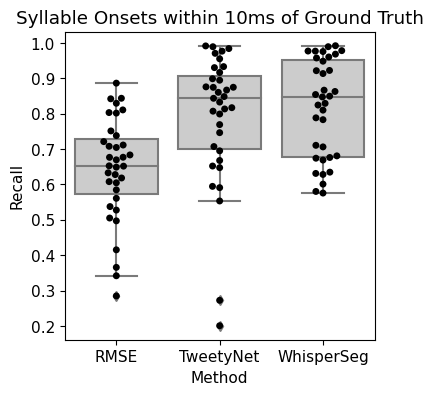

In [41]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

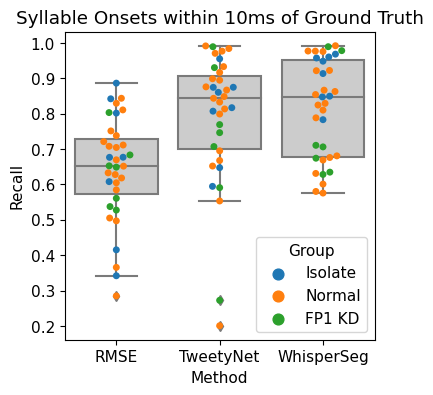

In [42]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', hue = 'Group', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_5532\2096052115.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'recall', fill = False, color = 'black', fliersize=0, whis= 0,


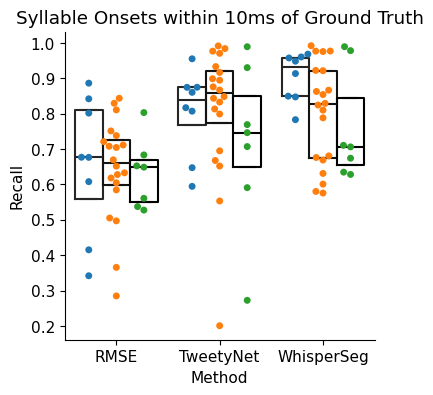

In [109]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', hue = 'Group', s = 5, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'recall', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')
sns.despine()

# Offsets

## Calc F1 Scores

In [77]:
all_seg_metrics = pd.DataFrame()
for Bird_ID in All_Birds[:]:

    #load whisperseg segmentation and reformat so it's consistent with avn
    wseg_segmentations = pd.read_csv('E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv")
    wseg_segmentations = wseg_segmentations.drop(columns = ['Unnamed: 0', 'cluster'])
    wseg_segmentations = wseg_segmentations.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})
    
    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, wseg_segmentations)
    #load ground truth segmentation and add to seg_data object
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #drop any files that aren't in the true seg table as they will cause errors
    to_drop = set(seg_data.seg_table.files.unique()) - set(seg_data.true_seg_table.files.unique())
    seg_data.seg_table = seg_data.seg_table[~seg_data.seg_table.files.isin(to_drop)]

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05, feature= 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature= 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.02
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #load tweetynet segmentations
    tweety_segs = pd.read_csv('E:\\Final_Bird_Dataset\\Old_Tweety_Segmentation\\' + Bird_ID + '.annot.csv')
    tweety_segs = vak_to_syll_table(tweety_segs)

    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, tweety_segs)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate F1 score for Tweetynet
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05, feature= 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature= 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.02
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])



In [78]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.920716,0.994475,0.857143,B145,0.05,whisper_seg
0,0.707379,0.780899,0.646512,B145,0.02,whisper_seg
0,0.739130,0.699588,0.783410,B145,0.05,Tweety_net
0,0.660194,0.680000,0.641509,B145,0.02,Tweety_net
0,0.942178,0.988711,0.899829,B236,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.987989,0.987685,0.988293,Y433,0.02,Tweety_net
0,0.972124,0.998958,0.946693,Y453,0.05,whisper_seg
0,0.842611,0.867639,0.818987,Y453,0.02,whisper_seg
0,0.969756,0.969283,0.970229,Y453,0.05,Tweety_net


## Get RMSE segmentation metrics

In [79]:
all_F1s = pd.DataFrame()

for i, Bird_ID in enumerate(All_Birds):
    print("Bird: " + str(i) + "/" + str(len(All_Birds)))
    
    song_folder = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/"+ Bird_ID + "/"
    ground_truth_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/" + Bird_ID + "/" + Bird_ID + "_syll_table.csv"
    
    #do MFCC Segmentation
    segmenter = segmentation.RMSEDerivative()
    seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                 upper_threshold = 0.006, 
                                                 lower_threshold = -0.1)
    
    #Add ground truth data
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature= 'offsets')
    
    seg_metrics = seg_data.seg_metrics
    seg_metrics["Bird_ID"] = [Bird_ID]
    all_F1s = all_F1s.append(seg_metrics)


Bird: 0/36
Bird: 1/36
Bird: 2/36
Bird: 3/36
Bird: 4/36
Bird: 5/36
Bird: 6/36
Bird: 7/36
Bird: 8/36
Bird: 9/36
Bird: 10/36
Bird: 11/36
Bird: 12/36
Bird: 13/36
Bird: 14/36
Bird: 15/36
Bird: 16/36
Bird: 17/36
Bird: 18/36
Bird: 19/36
Bird: 20/36
Bird: 21/36
Bird: 22/36
Bird: 23/36
Bird: 24/36
Bird: 25/36
Bird: 26/36
Bird: 27/36
Bird: 28/36
Bird: 29/36
Bird: 30/36
Bird: 31/36
Bird: 32/36
Bird: 33/36
Bird: 34/36
Bird: 35/36


In [80]:
all_F1s['method'] = 'RMSE'
all_F1s['max_gap'] = 0.02

In [81]:
all_seg_metrics = pd.concat([all_seg_metrics, all_F1s])

In [82]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.920716,0.994475,0.857143,B145,0.05,whisper_seg
0,0.707379,0.780899,0.646512,B145,0.02,whisper_seg
0,0.739130,0.699588,0.783410,B145,0.05,Tweety_net
0,0.660194,0.680000,0.641509,B145,0.02,Tweety_net
0,0.942178,0.988711,0.899829,B236,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.046429,0.046181,0.046679,B524,0.02,RMSE
0,0.048955,0.045086,0.053550,O434,0.02,RMSE
0,0.138545,0.132075,0.145682,S389,0.02,RMSE
0,0.035052,0.030026,0.042099,Y433,0.02,RMSE


In [83]:
all_seg_metrics.to_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s_offsets.csv')

## Plot F1 Scores

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt

In [80]:
all_seg_metrics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s_offsets.csv')

In [81]:
all_seg_metrics = all_seg_metrics[all_seg_metrics.Bird_ID != 'S389']

In [82]:
all_birds = pd.read_csv("D:\\Final_Bird_Dataset\\old_Bird_list.csv")
all_seg_metrics = pd.merge(all_seg_metrics, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

In [83]:
group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
all_seg_metrics['Group'] = [group_dict[x] for x in all_seg_metrics.Condition]

In [84]:
import seaborn as sns

In [85]:
all_seg_metrics = all_seg_metrics[all_seg_metrics.max_gap == 0.02]

In [86]:
all_seg_metrics.method = pd.Categorical(all_seg_metrics.method).reorder_categories(['RMSE', 'Tweety_net', 'whisper_seg'])
all_seg_metrics.method = all_seg_metrics.method.cat.rename_categories({'Tweety_net' : "TweetyNet", 
                                                                       'whisper_seg' : "WhisperSeg"})

In [87]:
plt.rcParams.update({'font.size': 11})

In [88]:
all_seg_metrics.groupby('method').mean(numeric_only  = True)

,Unnamed: 0,F1,precision,recall,max_gap
method,,,,,
RMSE,0.0,0.076765,0.073769,0.080818,0.02
TweetyNet,0.0,0.837624,0.883561,0.808205,0.02
WhisperSeg,0.0,0.781196,0.855747,0.726302,0.02


In [89]:
from scipy.stats import sem
print(sem(all_seg_metrics[all_seg_metrics.method == 'WhisperSeg'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'TweetyNet'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'RMSE'].F1))

0.03319168504485945
0.029045549321172898
0.010012048017091874


In [92]:
all_seg_metrics.groupby(['method', 'Group']).mean(numeric_only = True)

Unnamed: 0        F1  precision    recall  max_gap
method     Group                                                      
RMSE       FP1 KD          0.0  0.107833   0.104428  0.112407     0.02
           Isolate         0.0  0.085638   0.080201  0.092885     0.02
           Normal          0.0  0.062342   0.060465  0.064936     0.02
TweetyNet  FP1 KD          0.0  0.749308   0.844480  0.691431     0.02
           Isolate         0.0  0.846604   0.853147  0.845113     0.02
           Normal          0.0  0.864941   0.909405  0.834313     0.02
WhisperSeg FP1 KD          0.0  0.700561   0.805352  0.628992     0.02
           Isolate         0.0  0.874748   0.905237  0.847545     0.02
           Normal          0.0  0.771997   0.853589  0.711863     0.02

c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Method')

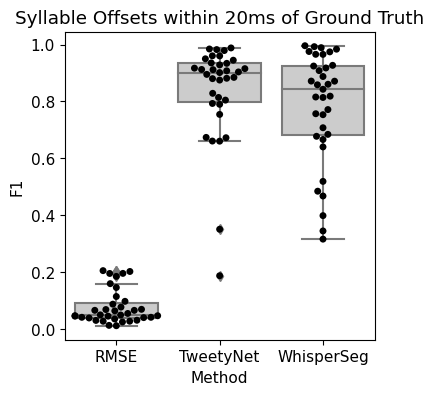

In [56]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')

c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Method')

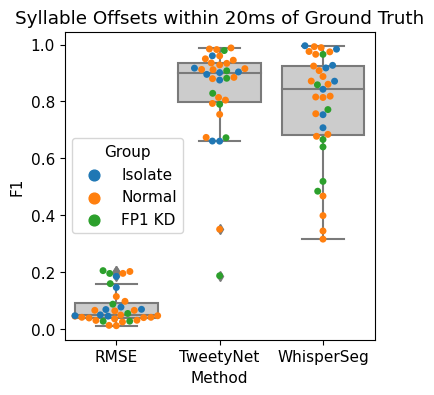

In [57]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', hue = 'Group', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_5532\389715988.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'F1', fill = False, color = 'black', fliersize=0, whis= 0,


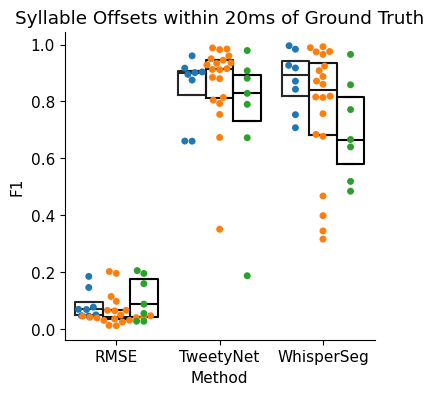

In [94]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', hue = 'Group', s = 5, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'F1', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
sns.despine()

Text(0, 0.5, 'Precision')

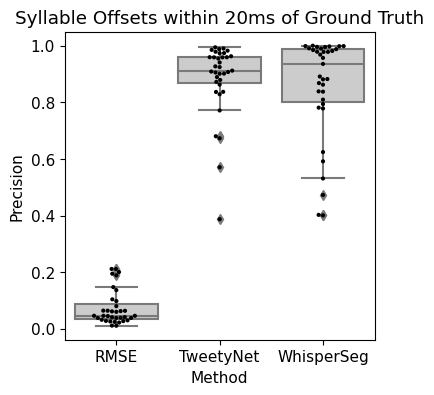

In [58]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', color = 'black', s = 3)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')

Text(0, 0.5, 'Precision')

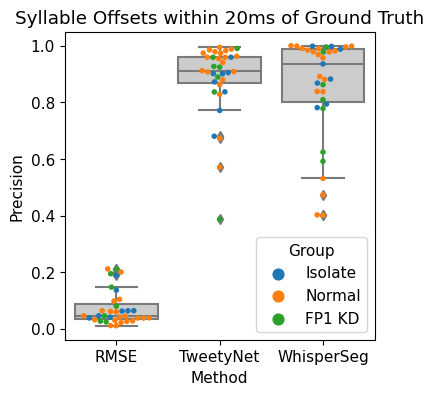

In [62]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', hue = 'Group', s = 4)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_5532\1885881686.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'precision', fill = False, color = 'black', fliersize=0, whis= 0,


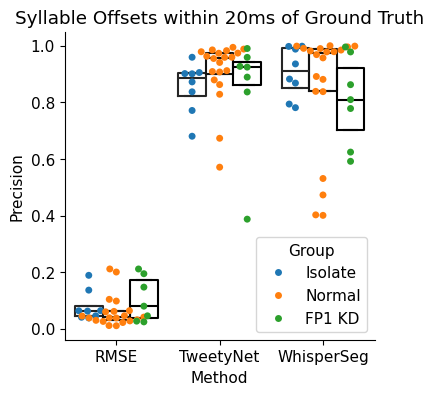

In [96]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', hue = 'Group', s = 5, dodge = True, legend = True)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'precision', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')
sns.despine()

Text(0, 0.5, 'Recall')

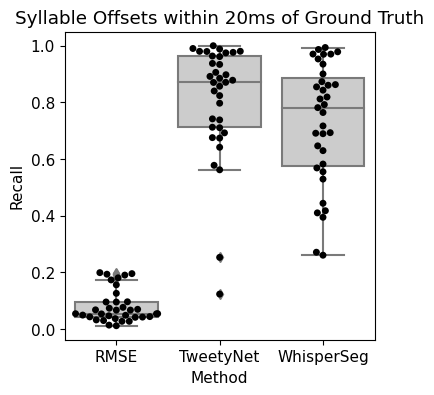

In [60]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

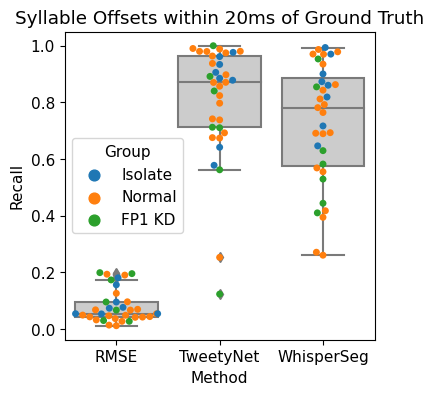

In [61]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', hue = 'Group', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_5532\2651503318.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'recall', fill = False, color = 'black', fliersize=0, whis= 0,


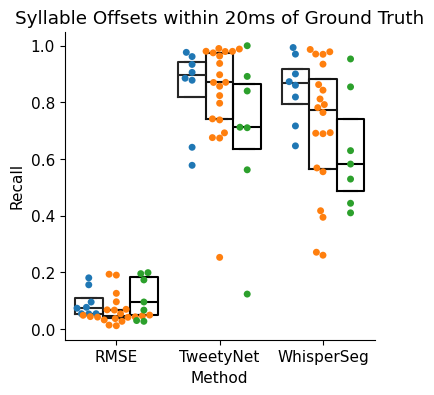

In [98]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', hue = 'Group', s = 5, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'recall', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')
sns.despine()